# chfem verification -- Flow in regular sphere pack

In [1]:
'''
ENVIRONMENT SETUP
'''

# install chfem
!pip install git+https://gitlab.com/cortezpedro/chfem_gpu.git@dev -q

# To enable c stdout printing in colab notebook
!pip install wurlitzer -q
import wurlitzer
wurlitzer.Wurlitzer.flush_interval=0.001
%load_ext wurlitzer

# necessary for pyvista plots
!pip install pyvista -q
!pip install piglet -q
!pip install pyvirtualdisplay -q
!apt-get -qq install xvfb
from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()
def pv_plot3D(img, flip_z=False, cmap='Greys', opacity=None, label='voxels', outline=True, scalar_bar_args=None):
  grid = pv.ImageData()
  xyz = ( img.shape[2], img.shape[1], img.shape[0] )
  grid.dimensions = xyz
  grid.point_data[label] = np.reshape( img, (img.size) )
  if not flip_z:
    grid.point_data[label] = np.reshape( img, (img.size) )
  else:
    grid.point_data[label] = np.reshape( img[-1::-1,-1::-1,:], (img.size) )
  plotter = pv.Plotter(notebook=True)
  if opacity is None:
    plotter.add_volume(grid, scalars=label, cmap=cmap, scalar_bar_args=scalar_bar_args)
  else:
    plotter.add_volume(grid, scalars=label, cmap=cmap, opacity=opacity, scalar_bar_args=scalar_bar_args)
  if outline:
    plotter.add_mesh(grid.outline(), color='k')
  ax = plotter.add_axes(interactive=True)
  if flip_z:
    plotter.camera_position = [(xyz[0]*2.8, -xyz[1]*1.8, -xyz[0]*1.2),
                               (xyz[0]*0.8, xyz[1]*0.4, xyz[2]*0.4),
                               (-0.29,0.28,-0.9144)]
  plotter.show()
  return None

# other imports
from matplotlib import pyplot as plt
import pyvista as pv
import numpy as np
import chfem
import os

In [2]:
'''
INPUT ARGUMENTS FOR SIMULATIONS
'''

# Input arguments
#########################################################################################################
SAMPLE = 'spheres'

DIMENSION = 128
SHAPE     = ( DIMENSION, DIMENSION, DIMENSION )
VOXEL     = 1e-03 / DIMENSION # volume = 1mm^3

SOLVER    = 'minres'
#SOLVER    = 'minres3'
#SOLVER    = 'minres2'
TOLERANCE = 1e-04
MAXIT     = 20_000

VIEW_SAMPLE_FLAG = True
VIEW_FIELDS_FLAG = (SOLVER != 'minres2')
#########################################################################################################

Generating sphere model ...
Done
Rendering image ...


/usr/local/lib/python3.10/dist-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


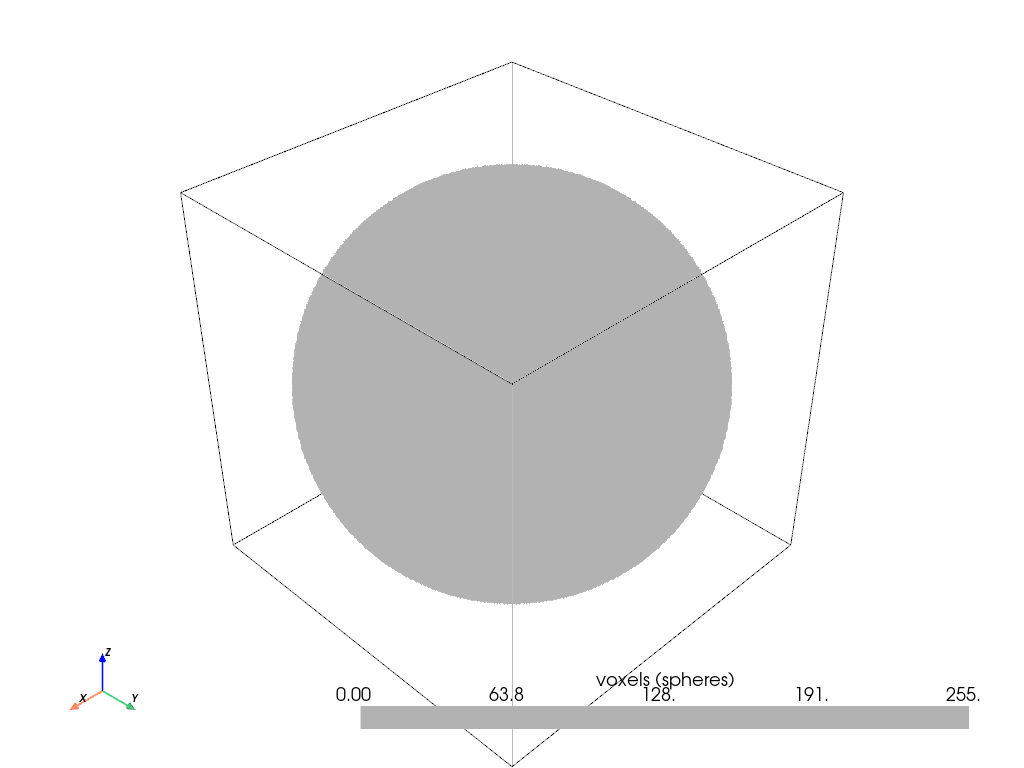

Done


In [3]:
'''
GENERATE AND VISUALIZE SAMPLE
'''

# Function to create sphere model
#########################################################################################################
def create_sphere( shape, position=None, radius=None, color=1, img=None, dtype='uint8' ):
  if position is None:
    position = tuple( d/2 for d in shape )
  if radius is None:
    radius = np.min(shape) / 2
  if img is None:
    img = np.zeros( shape, dtype=dtype )
  x = np.zeros( shape[1:], dtype='float32' )
  y = np.zeros( shape[1:], dtype='float32' ).transpose()
  x[0,:] = np.linspace(0.5,shape[2]-0.5,shape[2],dtype='float32')
  x[:,:] = x[0,:]
  y[0,:] = np.linspace(shape[1]-0.5,0.5,shape[1],dtype='float32')
  y[:,:] = y[0,:]
  y = y.transpose()
  for page in range(shape[0]):
    z = np.float32(page + 0.5)
    d = np.sqrt( (x-position[2])**2 + (y-position[1])**2 + (z-position[0])**2 )
    img[ page, d<=radius ] = color
  return img
#########################################################################################################

# Create image
#########################################################################################################
cwd = os.getcwd()

# Check if samples directory exists
if not os.path.exists(f'{cwd}/chfem_samples'):
  os.makedirs(f'{cwd}/chfem_samples')

print('Generating sphere model ...')
img = create_sphere(SHAPE)
print('Done')

if VIEW_SAMPLE_FLAG:
  print('Rendering image ...')
  pore_color = 0
  solid_color = np.min(img[img>pore_color])
  my_cmap = lambda x: np.array( [ (0.,0.5,0.8,1.0) if d < solid_color/255 else (0.7,0.7,0.7,1.0) for d in x ]  )
  pv_plot3D( img, cmap=my_cmap, opacity='foreground', label=f'voxels ({SAMPLE})')
  print('Done')
#########################################################################################################

In [4]:
'''
ABSOLUTE PERMEABILITY HOMOGENIZATION WITH chfem
'''

# Run simulations
#########################################################################################################
out_files = None
if VIEW_FIELDS_FLAG:
  out_files = f'{cwd}/chfem_samples/{SAMPLE}'

Keff = chfem.compute_property( 'permeability', img, voxel_size=VOXEL, direction='x',
                               solver=SOLVER, solver_tolerance=TOLERANCE, solver_maxiter=MAXIT,
                               output_fields=out_files )

Keff = np.array( Keff ) * 1e12 # conversion from m^2 to um^2
print('Permeability tensor, in um^2:')
print(Keff)

if VIEW_FIELDS_FLAG:
  print('Rendering velocity magnitude field ...')
  v = np.linalg.norm( chfem.import_vector_field_from_chfem(f'{out_files}_velocity_0.bin',SHAPE), axis=0 )
  v *= VOXEL**2 # quadratic scaling by VOXEL size. domain of simulations is normalized
  pv_plot3D(v, cmap='jet', opacity='linear', label='velocity magnitude [m/s]')
  print('Done')
#########################################################################################################